In [4]:
import numpy as np

import pandas as pd
import scipy.io

pd.options.display.max_columns = 10

mat  = scipy.io.loadmat("data/isomap.mat")
data = pd.DataFrame(mat["images"]).T
data.head()

,0,1,2,3,4,...,4091,4092,4093,4094,4095
0,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0
1,0.016176,0.016176,0.016176,0.016176,0.016988,...,0.0,0.0,0.0,0.0,0.0
2,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0
3,0.016176,0.016176,0.016176,0.024188,0.039859,...,0.0,0.0,0.0,0.0,0.0
4,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0


In [14]:
from scipy.spatial.distance import cdist

def distance_mat(data, epsilon=10, mode="euclidean"):
    def euclid_distance(data):
        return cdist(data, data, "euclidean")
    def manhat_distance(data):
        return cdist(data, data, "cityblock")
    
    distances = None
    if mode == "euclidean":
        distances = euclid_distance(data)
    else:
        distances = manhat_distance(data)
    
    values_in_epsilon = np.zeros((distances.shape[0], distances.shape[1]))
    for i in range(0, distances.shape[0]):
        for j in range(0, distances.shape[1]):
            if distances[i, j] <= epsilon:
                values_in_epsilon[i,j] = distances[i,j]
    
    return values_in_epsilon

In [15]:
def double_center_matrix(data):
    n_samples = data.shape[0]
    mean_rows = np.sum(data, axis=0) / n_samples
    mean_cols = (np.sum(data, axis=1) / n_samples)[:, np.newaxis]
    total_mean = mean_rows.sum() / n_samples
    
    data -= mean_rows
    data -= mean_cols
    data += total_mean
    return data

In [20]:
def calc_mds(data, n_components=2):
    data = double_center_matrix(data)
    eigen_values, eigen_vectors = np.linalg.eig(data)
    eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]
    
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)
    eigen_pairs = np.real(np.array(eigen_pairs))
    output_matrix = np.hstack([eigen_pairs[i, 1].reshape(data.shape[1], 1) for i in range(n_components)])
    
    return output_matrix

In [35]:
from sklearn.utils.graph import graph_shortest_path

def generate_isomap(data, n_components=2, epsilon=10, mode="euclidean"):
    data = distance_mat(data, epsilon=epsilon, mode=mode)
    graph = graph_shortest_path(data, directed=False)
    graph = -0.5*(graph ** 2)
    
    output_matrix = calc_mds(graph, n_components)
    return output_matrix, data

In [36]:
output_matrix, graph = generate_isomap(data, 2, epsilon=10, mode="euclidean")
print(graph)

[[0.         0.         6.74323967 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [6.74323967 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


<ipython-input-20-345b69544ac0>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  eigen_pairs = np.real(np.array(eigen_pairs))


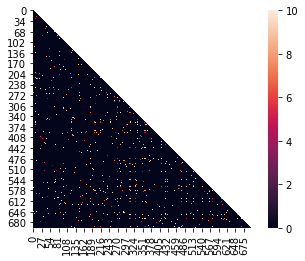

In [39]:
import seaborn as sns

mask = np.triu(np.ones_like(graph, dtype=bool))

sns.heatmap(graph, mask=mask, vmin=0, vmax=10, square=True);

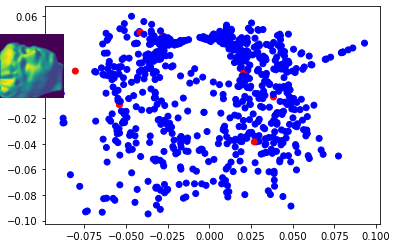

In [76]:
import matplotlib.pyplot as plt

colors = []

image_idx0 = data.iloc[0].to_numpy().reshape((64,64))
x_loc_idx0, y_loc_idx0 = output_matrix[0, 0], output_matrix[0, 1]

for idx, point in enumerate(output_matrix):
    if idx % 100 != 0:
        colors.append("blue")
    else:
        colors.append("red")

fig = plt.figure()
plt.scatter(output_matrix[:, 0], output_matrix[:, 1], c=colors)
fig.figimage(image_idx0, 0, 150)

In [81]:
output_matrix, graph = generate_isomap(data, 2, epsilon=1000, mode="manhattan")
print(graph)

[[  0.         965.31026348 257.36994485 ...   0.           0.
  801.11789216]
 [965.31026348   0.         998.80539216 ... 591.33363971   0.
    0.        ]
 [257.36994485 998.80539216   0.         ...   0.           0.
  854.53792892]
 ...
 [  0.         591.33363971   0.         ...   0.           0.
  736.96179534]
 [  0.           0.           0.         ...   0.           0.
  906.32530637]
 [801.11789216   0.         854.53792892 ... 736.96179534 906.32530637
    0.        ]]


<ipython-input-20-345b69544ac0>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  eigen_pairs = np.real(np.array(eigen_pairs))


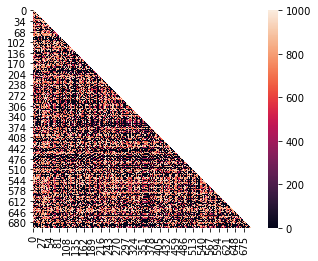

In [83]:
mask = np.triu(np.ones_like(graph, dtype=bool))

sns.heatmap(graph, mask=mask, vmin=0, vmax=1000, square=True);

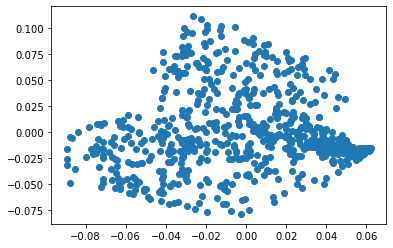

In [84]:
fig = plt.figure()
plt.scatter(output_matrix[:, 0], output_matrix[:, 1])

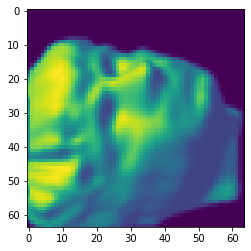

In [90]:
input_images = np.zeros((64,64, 698))

for idx in range(0,698):
    temp = data.iloc[idx].to_numpy().reshape((64,64))
    input_images[:, :, idx] = temp
plt.imshow(input_images[:, :, 0])

In [94]:
input_matrix = np.zeros((4096, 698))

for idx in range(0, 698):
    input_arr = input_images[:,:,idx].flatten()
    img_std = (input_arr - input_arr.mean()) / input_arr.std()
    input_matrix[:, idx] = img_std
input_matrix.shape

(4096, 698)

In [95]:
cov_matrix = np.cov(input_matrix.T)
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

In [97]:
order = eigen_values.argsort()[::-1]
eigen_values = eigen_values[order]
eigen_vectors = eigen_vectors[:, order]

projection_data = np.matmul(input_matrix, eigen_vectors)

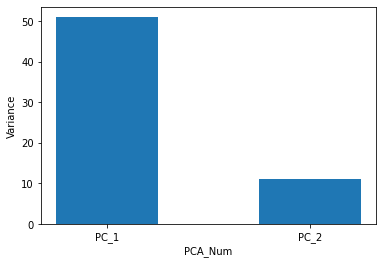

In [102]:
pca_count = 2

compressions = np.arange(1,3)
plt.bar(compressions, np.real(eigen_values/sum(eigen_values))[0:pca_count]*100, width=0.5, 
        tick_label=["PC_"+str(pca) for pca in compressions])
plt.ylabel("Variance")
plt.xlabel("PCA_Num");

In [104]:
eigen_vectors.shape

(698, 698)

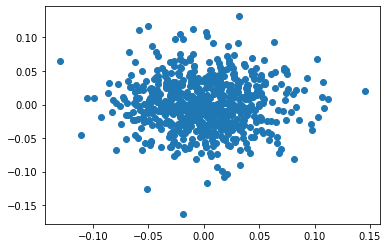

In [105]:
x_coords, y_coords = [], []
for idx in range(0, 698):
    x_coords.append(eigen_vectors[0, idx])
    y_coords.append(eigen_vectors[1, idx])
plt.scatter(x_coords, y_coords)